# Airbus Ship Detection Challenge
Find ships on satellite images as quickly as possible

## Prepare datasets
The train_ship_segmentations.csv file provides the ground truth (in run-length encoding format) for the training images. The sample_submission files contains the images in the test images.

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image

from skimage.data import imread
import matplotlib.pyplot as plt
import os
import random
np.set_printoptions(threshold=np.inf)   # print all numpy ndarray

Specify datasets location

In [2]:
dataset_train = '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/train_v2'
csv_train =     '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/train_ship_segmentations_v2.csv'

dataset_test  = '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/test_v2'
csv_test =      '/media/zitong/Seagate Backup Plus Drive/datasets/airbus/final.csv'   # should not use .csv file with empty image !

### Delete useless images

Total number of ship

In [3]:
# read_csv_file
df = pd.read_csv(csv_train)

print(type(df))
totalLines = df.shape[0]
print("Dataframe lines: ",df.shape[0])
print("Dataframe dimension: ",df.shape)

<class 'pandas.core.frame.DataFrame'>
Dataframe lines:  231723
Dataframe dimension:  (231723, 2)


Drop the rows where at least one element is missing. (delete annotations without ship)

In [4]:
df = df.dropna(axis=0)
num_of_ships = df.shape[0]
print("Instances: ",num_of_ships)
# print("percent of useful data: ", num_of_ships / totalLines * 100)

Instances:  81723


Create an empty set to store images with ship. The reason we use set is to avoid duplicate elements.
Note that the set method initialize images with an empty set.

Use df.iloc[] to access elements in the 2d array https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
We only care about the id of the image in col 1. The return type of df.iloc[line,0] is a string.

ims is a list which stores all the file name (.jpg) stored in the training set folder.

In [5]:
images = set()
# print(type(df.iloc[1, 0]))
for line in range(num_of_ships):
    if df.iloc[line,0] not in images:
        images.add(df.iloc[line,0])
print("Images with ship: ",len(images))

# Delete images without ship
count = 0
ims = os.listdir(dataset_train)
# print(type(ims))
# print(ims[0])

for im in ims:
    if im not in images:
        os.remove(os.path.join(dataset_train, im))
        print(im, "REMOVED")
        count += 1
print('%d images is deleted.'%(count))

Images with ship:  42556
0 images is deleted.


### Show RLE

#### Convert RLE to numpy
Convert mask_rle, a string that stores mask information, to np.ndarry(np.unit8). The reason we let starts -= 1 is because numpy array starts at index 0.  


asarray() converts a list to a numpy array. 

the double colon (::) gets every n-th element from the list / array

The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together etc. If the passed iterators have different lengths, the iterator with the least items decides the length of the new iterator.



In [6]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

# shape: (height,width) , 1 - mask, 0 - background
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    print(type(s[0]))
    starts =  np.asarray(s[0::2], dtype=int)
    lengths = np.asarray(s[1::2], dtype=int)

    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

#### Show Mask

<class 'str'>
Area:  177


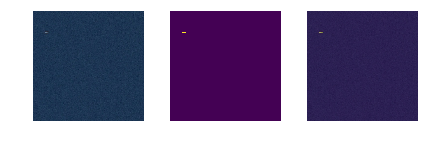

In [7]:
def csv_show_rle(ImageId, dataset_dir, df):
    img = imread(os.path.join(dataset_dir, ImageId))
    rle_masks = df.loc[df['ImageId'] == ImageId, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in rle_masks:
        binary_mask = rle_decode(mask)
        print('Area: ', np.sum(binary_mask))
        all_masks += binary_mask

    fig, axarr = plt.subplots(1, 3)
    axarr[0].axis('off'),
    axarr[1].axis('off'),
    axarr[2].axis('off')
    axarr[0].imshow(img),
    axarr[1].imshow(all_masks),
    axarr[2].imshow(img)
    axarr[2].imshow(all_masks, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    # plt.savefig( os.path.join(ROOT_DIR, '../tmp', 'tmp.png') )
    plt.show()


# dataset_train = '../datasets/ships_train2018'
# dataset_test  = '../datasets/ships_test2018'
# csv_train =     '../datasets/train_ship_segmentations_v2.csv'
# csv_test =      '../2_submit/final.csv'   # should not use .csv file with empty image !

df = pd.read_csv(csv_train)
# ImageId_list = ['0ba29cbcf.jpg', '00fd8e126.jpg', '0b1b3d75b.jpg']
ImageId_list = os.listdir(dataset_train)
ImageId = random.choice(ImageId_list)
csv_show_rle(ImageId, dataset_train, df)